# Setup & Config

In [241]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

file_path = Path("../data/aqi_data_labeled.csv")

df = pd.read_csv(file_path, low_memory=False)

print("Columns:", list(df.columns))


Columns: ['Date', 'AQI', 'PM25', 'Ozone', 'NO2', 'SO2', 'CO', 'Windspeed', 'Temperature', 'AQI_Label', 'AQI_Class']


# Parse Data & Clean AQI

In [242]:
# Convert date column to datetime
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y", errors="coerce")

print("Rows before cleaning:", len(df))

# Drop rows with missing Date or AQI
df = df.dropna(subset=["Date", "AQI"]).reset_index(drop=True)

print("Rows after cleaning:", len(df))

Rows before cleaning: 1095
Rows after cleaning: 1095


# Missing Values & Summary

In [243]:
# Show all columns missing counts
missing_counts = df.isna().sum()
print("Missing values per column:\n")
print(missing_counts)

# Summary statistics for numeric columns
print("\nNumeric summary:")
display(df.drop(columns=["AQI_Class"]).describe(include=[float, int]).T)

Missing values per column:

Date           0
AQI            0
PM25           0
Ozone          0
NO2            0
SO2            0
CO             0
Windspeed      0
Temperature    0
AQI_Label      0
AQI_Class      0
dtype: int64

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
AQI,1095.0,85.868493,36.355837,31.000000,60.000000,74.000000,101.000000,281.000000
PM25,1095.0,11.006166,4.681787,2.561905,8.278617,10.382698,12.988393,44.270025
Ozone,1095.0,0.031417,0.009073,0.003314,0.024222,0.033065,0.038433,0.054973
NO2,1095.0,13.324591,6.140623,3.399586,8.509096,11.973124,17.398393,37.962878
SO2,1095.0,0.300020,0.211074,-0.033333,0.150764,0.273611,0.420312,2.711458
CO,1095.0,0.338965,0.134244,0.148111,0.232657,0.304081,0.418275,0.913868
Windspeed,1095.0,95.525056,11.454601,47.022000,89.000068,95.924479,102.870433,127.789757
Temperature,1095.0,64.355721,8.804677,44.299242,57.391681,63.461458,71.545766,87.906250


# Label Distribution

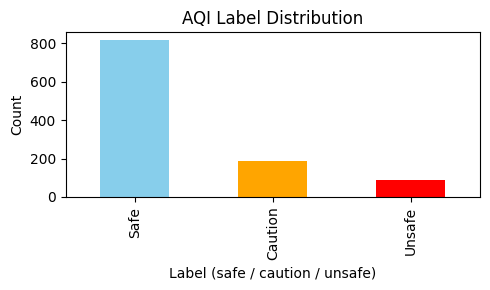

In [244]:
if "AQI_Label" in df.columns:
    plt.figure(figsize=(5,3))
    df["AQI_Label"].value_counts().plot(kind="bar", color=["skyblue","orange","red"])
    plt.title("AQI Label Distribution")
    plt.xlabel("Label (safe / caution / unsafe)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("AQI_Label column not found.")

# AQI Time Series (daily + 7-day mean)

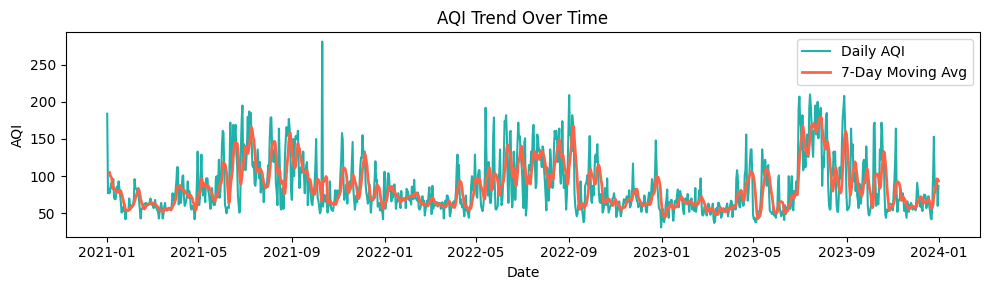

In [245]:
ts = df[["Date","AQI"]].dropna().sort_values("Date").set_index("Date")

plt.figure(figsize=(10,3))
plt.plot(ts.index, ts["AQI"], label="Daily AQI", color="lightseagreen")
plt.plot(ts.index, ts["AQI"].rolling(7, min_periods=4).mean(),
         label="7-Day Moving Avg", color="tomato", linewidth=2)
plt.title("AQI Trend Over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.show()

# Monthly AQI Pattern (Boxplot)

<Figure size 800x300 with 0 Axes>

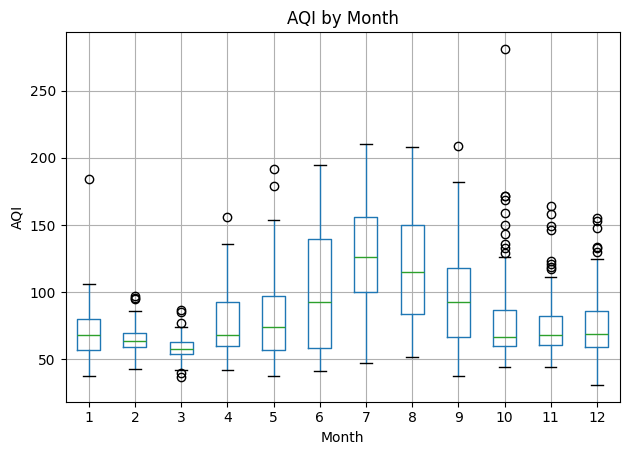

In [246]:
df["Month"] = df["Date"].dt.month

plt.figure(figsize=(8,3))
df.boxplot(column="AQI", by="Month")
plt.title("AQI by Month")
plt.suptitle("")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()

# Monthly Average AQI (Bar chart)

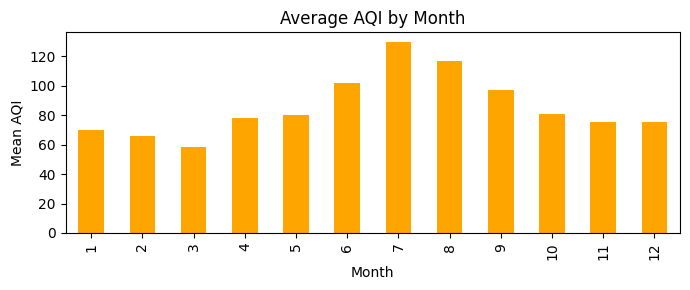

In [247]:
monthly_mean = df.groupby("Month")["AQI"].mean()

plt.figure(figsize=(7,3))
monthly_mean.plot(kind="bar", color="orange")
plt.title("Average AQI by Month")
plt.xlabel("Month")
plt.ylabel("Mean AQI")
plt.tight_layout()
plt.show()

# Pollutant Time Series Comparison

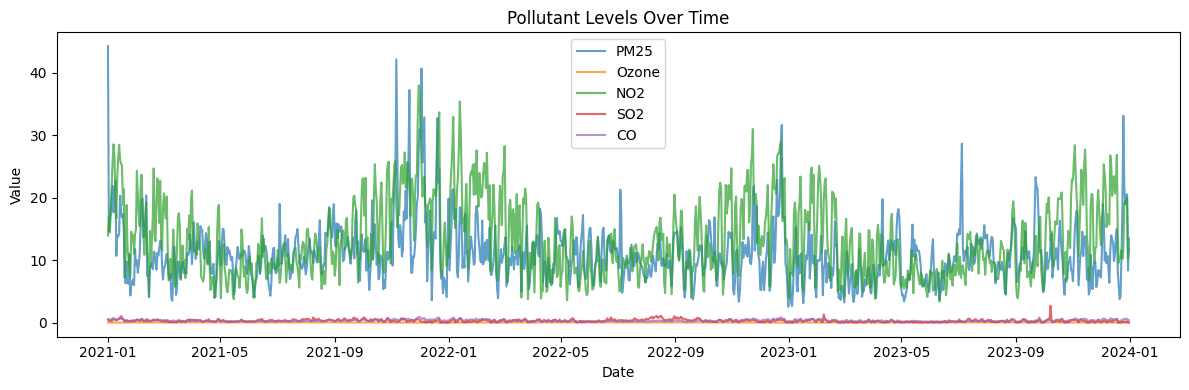

In [248]:
pollutants = ["PM25", "Ozone", "NO2", "SO2", "CO"]

plt.figure(figsize=(12,4))
for col in pollutants:
    plt.plot(df["Date"], df[col], label=col, alpha=0.7)

plt.title("Pollutant Levels Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# AQI vs Major Features Scatter Plot

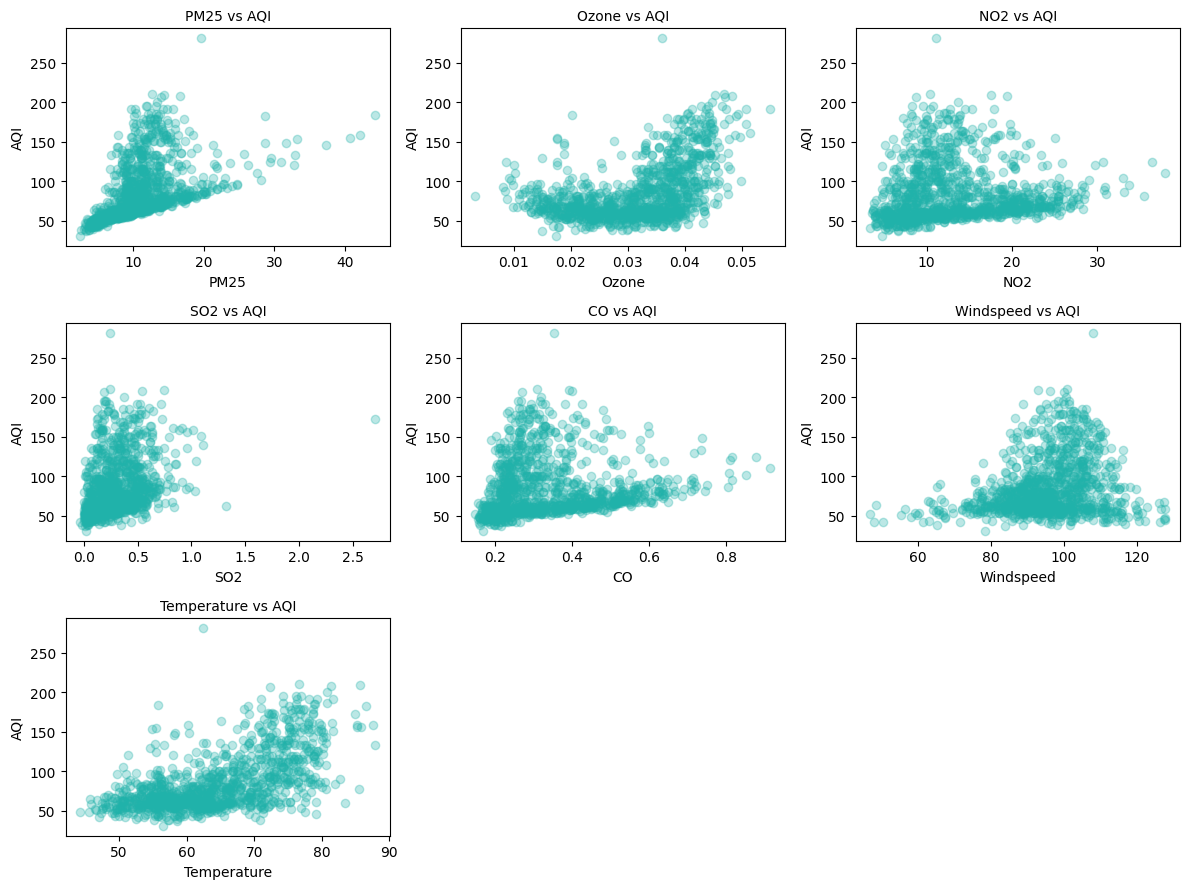

In [249]:
features = ["PM25", "Ozone", "NO2", "SO2", "CO", "Windspeed", "Temperature"]
y_name = "AQI"

n = len(features)
rows = int(np.ceil(n / 3))

plt.figure(figsize=(12, 3 * rows))
for i, col in enumerate(features, 1):
    plt.subplot(rows, 3, i)
    plt.scatter(df[col], df[y_name], alpha=0.3, color="lightseagreen")
    plt.title(f"{col} vs {y_name}", fontsize=10)
    plt.xlabel(col)
    plt.ylabel(y_name)
plt.tight_layout()
plt.show()


# AQI Category by Month (Stacked Bar)

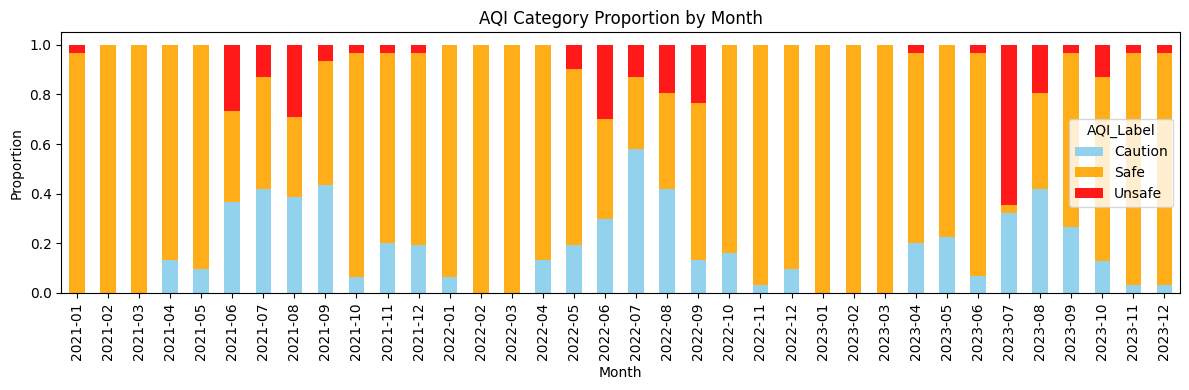

In [250]:
if "AQI_Label" in df.columns:
    df_sorted = df.copy()
    df_sorted["Month"] = df_sorted["Date"].dt.to_period("M")

    monthly_counts = df_sorted.groupby(["Month", "AQI_Label"]).size().unstack(fill_value=0)

    monthly_props = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

    monthly_props.plot(
        kind="bar",
        stacked=True,
        figsize=(12,4),
        color=["skyblue", "orange", "red"],
        alpha=0.9
    )

    plt.title("AQI Category Proportion by Month")
    plt.xlabel("Month")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()
else:
    print("AQI_Label not found.")


# Pollutant to Pollutant Correlation Heatmap

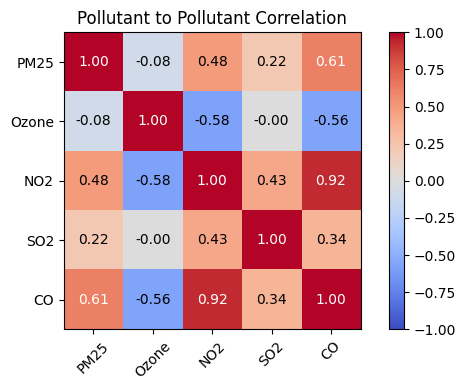

In [251]:
pollutants = ["PM25", "Ozone", "NO2", "SO2", "CO"]
corr_poll = df[pollutants].corr()

plt.figure(figsize=(6,4))
im = plt.imshow(corr_poll.values, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(pollutants)), pollutants, rotation=45)
plt.yticks(range(len(pollutants)), pollutants)

for i in range(len(pollutants)):
    for j in range(len(pollutants)):
        val = corr_poll.values[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center",
                 color="white" if abs(val) > 0.6 else "black")

plt.title("Pollutant to Pollutant Correlation")
plt.tight_layout()
plt.show()


# Correlation Matrix

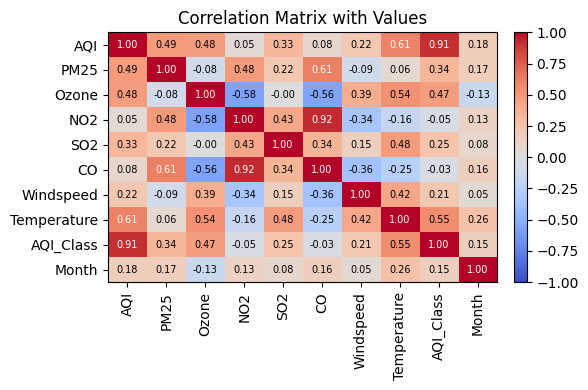

In [252]:
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(6,4))
im = plt.imshow(corr.values, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)

for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        val = corr.values[i, j]
        plt.text(j, i, f"{val:.2f}",
                 ha="center", va="center",
                 color="white" if abs(val) > 0.6 else "black",
                 fontsize=7)

plt.title("Correlation Matrix with Values")
plt.tight_layout()
plt.show()
